### **Pixel level segmentation in PETS dataset**

**Author**: Matteo Di Giorgio - 353719

### **Introduction**

**Project assigment**
- Project objective:
    - Pixel level segmentation in PETS dataset

- Dataset:
    - Pets dataset provides the segmentation mask of a large variety of pets https://www.robots.ox.ac.uk/evge/data/pets/

- Network model:
    - A segmentation model should be used for this task. UNet is a good choice, but you can experiments with different architectures.

- Detailed information:
    - Starting from a reb image of a pet the network should output a segmentation mask of the pet. Only a single pet is present in each image.
    - Intersection over Union, L1 distance are good metrics to evaluate the results.

- Additional notes:
    - Experiment also with in-the-wild samples (meaning images not extracted from the pets dataset: e.g. found online or taken by a smartphone). Does the network perform well over these images?
    - That happens if more than on animal is in one image? How does the model perform?

**About Dataset**  
The Oxford-IIIT Pet Dataset is a 37 category pet dataset with roughly 200 images for each class created by the Visual Geometry Group at Oxford. The images have a large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation.
The dataset comprises a total of approximately 7,400 images.

![DATASET](https://production-media.paperswithcode.com/datasets/Oxford-IIIT_Pets-0000000571-4547798f_WG4TMz3.jpg)


/var/folders/ts/3n8g174j4hl56qjlwd31sqmh0000gn/T/ipykernel_1502/359742869.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


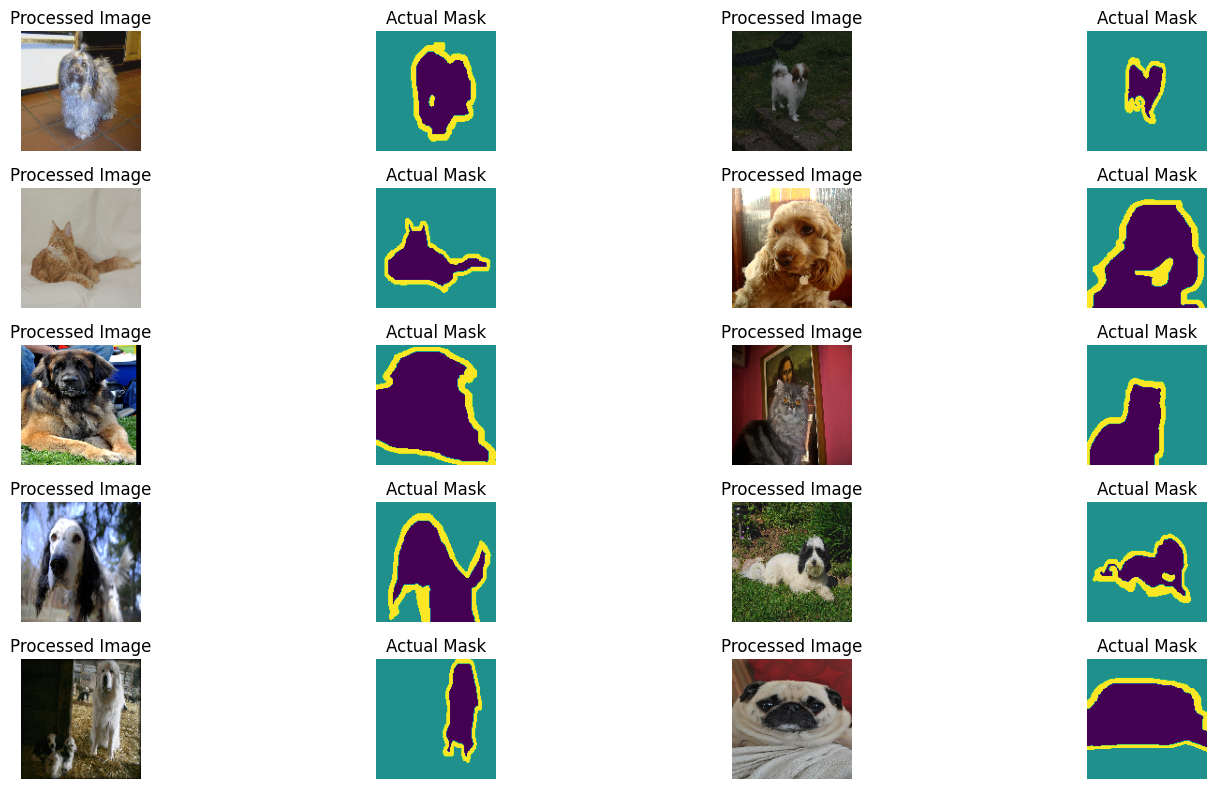

In [1]:
import pandas as pd
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
import random

# Batch size for testing
BATCH_SIZE_TEST = 10

# Oxford IIIT Pets Segmentation dataset load
test = os.path.join('oxford-iiit-pet', 'test')
test_dataset = torchvision.datasets.OxfordIIITPet(root=test, split="test", target_types="segmentation", download=True)

# Send the input object to the GPU if available
class ToDevice(torch.nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={self.device})"

# Class to create a custom dataset
class PetsDataset(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)
        
        # Common Trasformation of the input and target
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        # Post trasformation of the input and target
        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)

# function to create a trimap for segmentation
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

# function to convert arguments to dictionary
def args_to_dict(**kwargs):
    return kwargs

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


# Data Augmentation
transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([
        ToDevice(get_device()),
        T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
        T.RandomHorizontalFlip(p=0.5),
    ]),
    post_transform=T.Compose([
        T.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

# Create the test dataset
pets_test = PetsDataset(
    root=test,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

# Create the test dataloader
pets_test_dataloader = torch.utils.data.DataLoader(
    pets_test,
    batch_size=BATCH_SIZE_TEST,
    shuffle=True,
)


(test_pets_inputs, test_pets_targets) = next(iter(pets_test_dataloader))

transform = T.ToPILImage()

# Display the processed image and the actual mask
fig, axs = plt.subplots(BATCH_SIZE_TEST // 2, 4, figsize=(16, 8))

for i in range(BATCH_SIZE_TEST):
    row = i // 2
    col = (i % 2) * 2
    axs[row, col].imshow(transform(test_pets_inputs[i]))
    axs[row, col].set_title('Processed Image')
    axs[row, col].axis('off')
    axs[row, col + 1].imshow(test_pets_targets[i].cpu().numpy().squeeze(0))
    axs[row, col + 1].set_title('Actual Mask')
    axs[row, col + 1].axis('off')

plt.tight_layout()

### **UNET**

The U-Net is a type of convolutional neural network (CNN) that is primarily used for image segmentation tasks.
Here's a breakdown of the U-Net architecture:

### Architecture

1. **Encoder (Contracting Path)**:
   - The left side of the U-Net, also known as the contracting path, follows the typical architecture of a convolutional network.
   - It consists of repeated application of two 3x3 convolutions (unpadded convolutions) each followed by a ReLU activation function and a 2x2 max pooling operation with stride 2 for downsampling.
   - At each downsampling step, the number of feature channels is doubled.

2. **Bottleneck**:
   - This is the bottom of the U, where the resolution of the feature maps is the lowest, but the depth is the highest.
   - It consists of two 3x3 convolutions followed by a ReLU activation.

3. **Decoder (Expanding Path)**:
   - The right side of the U-Net, also known as the expanding path, consists of upsampling the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels.
   - Then, it concatenates the corresponding cropped feature map from the contracting path.
   - This is followed by two 3x3 convolutions, each followed by a ReLU activation.
   - The upsampling steps help to regain the spatial resolution lost during the downsampling steps in the contracting path.

4. **Output Layer**:
   - The final layer is a 1x1 convolution that maps each 64-component feature vector to the desired number of classes.

### Skip Connections

One of the key features of U-Net is the skip connections between the corresponding layers of the encoder and decoder. These connections concatenate feature maps from the encoder to the decoder, which helps the network to retain the high-resolution features learned during the downsampling path and improve the localization accuracy of the segmentation.

### Advantages

- **Precision**: U-Net is known for its precision in segmenting images at a pixel level, which is crucial for applications like biomedical image segmentation.
- **Data Efficiency**: It works well even with a small amount of training data, which is often a constraint in medical imaging.
- **Speed**: The architecture allows for efficient training and inference, making it suitable for real-time applications.

### Applications

U-Net is extensively used in various image segmentation tasks beyond biomedical imaging, such as:
- Satellite image segmentation
- Agricultural image analysis
- Autonomous driving (segmentation of road scenes)
- Any other domain where precise pixel-level segmentation is required.

The U-Net architecture’s ability to capture both the context and the details of an image makes it a powerful tool for a wide range of segmentation tasks.

<center>
<img src="Images/Unet.png" alt="Unet Loss Batch A" width="700"/>
</center>

### **ABLATION STUDY:** 
### 1. LOSS AND BATCH SIZE
Conducting a study on the loss function and batch size in the context of image segmentation is crucial for several reasons, including improving model performance, computational efficiency, and training stability.

**Loss Function (1 - Metric)**

The loss function defined as (1 - Metric) is a straightforward and effective technique used in various machine learning contexts. This formulation converts a performance metric (such as accuracy or Intersection over Union, IoU) into a loss function, directly penalizing incorrect predictions. When the metric is high, the loss is low, encouraging the model to maximize the metric itself. This approach is commonly used in classification and segmentation problems to enhance overall model performance.

**Loss Function -Log(Metric)**

The loss function -Log(Metric) introduces exponential sensitivity to changes in the performance metric. This approach is particularly useful when the metric produces values close to 1, as it amplifies the impact of small improvements, facilitating faster and more stable model convergence. The logarithmic penalty helps better manage outliers and smooths the gradient during training, making the learning process less prone to oscillations.

Setup:
- Batch size Test = 20
- Early Stopping patience = 3
- Optimizer Adam
- Learning Rate 0.001
- Activation Function: Softmax

Results of two different custom Loss: 

- Loss = (1 - IoUMetric)  --> label: Config A
- Loss = -Log(IoUMetric)  --> label: Config B




- RESULT CONFIG A:
<center>
<img src="Images/Unet_LossBatchA.png" alt="Unet Loss Batch A" width="800"/>
</center>

- RESULT CONFIG B:
<center>
<img src="Images/Unet_LossBatchB.png" alt="Unet Loss Batch B" width="800"/>
</center>

- COMPARISON CONFIG A AND B:

<center>
<img src="Images/Unet_LossBatchAB.png" alt="Unet Loss Batch A" width="800"/>
</center>


<u> **In light of the results obtained, configuration B with a batch size of 4 turns out to be the best solution.** </u>



From an initial test with **CONFIG B** we can see:

<div style="display: flex; gap: 10px;">

  <img src="runs/BatchSizeLoss/unet_configB_4/pred.png" alt="Pred_configB4" width="500"/>
  <img src="runs/BatchSizeLoss/unet_configB_4/plot_history.png" alt="Pred_configB5" width="700"/>

</div>



### Further study: 
Performance comparison of the best configuration obtained with the same configuration but without Data Augmentation in order to understand on a performance level how the latter affects the model. 

<center>
  <img src="Images/CompareAugmentation.png" alt="Unet_CompareAugmentation" width="800"/>
</center>

As can be seen, the lack of augmentation worsens the model in all respects (performance, timing, ...) and furthermore, the graphs show unstable training mainly in the initial phase.

### 2. STUDY BEST LEARNING RATE AND OPTIMIZER

The learning rate determines the speed at which the model learns from the data, significantly influencing the convergence and the final quality of the model. A learning rate that is too high can cause instability and non-convergence, while one that is too low can slow down the training and lead to a suboptimal solution.
<center>
  <img src="Images/Learning Rate.jpeg" alt="Unet_LR" width="250"/>
</center>

Optimizers, on the other hand, manage the updating of the model's weights. Algorithms such as SGD (Stochastic Gradient Descent), Adam and RMSprop have different properties and performances based on the nature of the problem and the data. For instance, Adam combines the advantages of two other optimizers, RMSProp making it effective for a wide range of problems.



 
**Result Test:** 

<center>
  <img src="Images/Unet_OptimizerLR.png" alt="Unet_Optimizer" width="750"/>
  </center>

### 3. STUDY OPTIMIZER WITH SCHEDULER

Starting from a predefined learning rate, a StepLR scheduler with:
 - step_size=10
    - Period of learning rate decay
 - gamma=0.1 
    - Multiplicative factor of learning rate decay. Default: 0.1

is used and it is visualised how the network reacts to the insertion of the scheduler

<center>
 <img src="Images/Unet_Scheduler.png" alt="Unet_Scheduler" width="750"/>
 </center>

An additional study is conducted by comparing the configuration with Scheduler StepLR, namely **configuration 2**, with the best configuration without a Scheduler, namely **configuration 5**, training them for the same number of epochs.

<center>
 <img src="Images/Unet_SchedulerComparison.png" alt="Unet_SchedulerComparison" width="750"/>
 </center>


**The difference in performance is minimal, i decided to keep the scheduler as a matter of training stability (overfitting), with a starting Learning Rate of 0.0001**

### 4. STUDY WEIGHT DECAY

**Weight Decay:**
Regularizes the model weights, preventing overfitting.
**Up to now a weight decay = 0 has been considered**

Also known as L2 regularization or weight regularization, is a technique commonly used in machine learning and neural network training to prevent overfitting. In the context of neural networks, weight decay works by adding a penalty term to the loss function during training. This penalty is proportional to the squared magnitude of the weights in the network. The effect is that during training, the network not only tries to minimize the error on the training data but also tries to keep the weights as small as possible.



<center>
<img src="Images/Unet_WeightDecay.png" alt="Unet_WeightDecay" width="750"/>
</center>

**The solution with a weight decay of 0.0001 is slightly better in terms of performance but considerably better in terms of time.
This solution is adopted**

- Result after Study 2 - 3 - 4: 
    - Generalisation: The model seems to generalise well, as indicated by the small difference between training and validation losses.
    - Stability: The losses become stable after some initial fluctuations, which is typical in many training processes.
    - Performance: The low final loss values suggest a good performance of the model.

<center>
<img src="runs/WeightDecay/unet_WD_0.0001/predictions_plot.png" alt="Unet_WeightDecay_predplot" width="800"/>
</center>

### 5. STUDY MODIFY NETWORK (add dropout,another activation function,disable part)

**Dropout**

Is a regularization technique used in neural networks to prevent overfitting. It randomly deactivates a fraction of neurons during training, forcing the network to learn redundant representations and preventing reliance on specific neurons. This encourages better generalization to unseen data.

<center>
<img src="Images/Unet_Dropout.png" alt="Unet_Dropout" width="800"/>
</center>

It can be seen that the influence of the dropout at the performance level is almost zero, **but results in improved training in the afterConv_0.1 case.**

**Activation Function in Layers** 

Activation functions are a crucial component in neural networks, significantly influencing the model's performance and learning capability. They introduce non-linearity into the model, allowing it to learn and represent complex relationships in the data. Without non-linear activation functions, a neural network would simply be a combination of linear transformations, unable to solve complex non-linear problems.


<h3>ReLU (Rectified Linear Unit):</h3>
<p><strong>Formula:</strong> <code>f(x) = max(0, x)</code></p>
<ul>
  <li><strong>Pros:</strong> Simple and effective, helps mitigate the vanishing gradient problem.</li>
  <li><strong>Cons:</strong> Can cause the "dying ReLU" problem where neurons can become inactive (output constantly zero).</li>
</ul>

<h3>Leaky ReLU:</h3>
<p><strong>Formula:</strong> <code>f(x) = 
  <span>&#123;</span>
  <span>&#10;&emsp;x &nbsp;  if &nbsp; x &gt; 0 &nbsp; or
  &emsp;&#945;x &nbsp; if &nbsp; x &le; 0
  </span>
  <span>&#125;</span>
</code></p>
<ul>
  <li><strong>&#945;:</strong> Tipically = 0.01
  <li><strong>Pros:</strong> Solves the "dying ReLU" problem by allowing a small gradient when the input is negative.</li>
  <li><strong>Cons:</strong> The choice of the parameter α can affect performance.</li>
</ul>

<h3>PReLU (Parametric ReLU):</h3>
<p><strong>Formula:</strong> <code>f(x) = 
  <span>&#123;</span>
  <span>&#10;&emsp;x &nbsp; if &nbsp; x &gt; 0 &nbsp; or
  &emsp;&#945;x &nbsp; if &nbsp; x &le; 0  </span>
  <span>&#125;</span>
</code></p>
<ul>
  <li><strong>&#945;:</strong> is a parameter that is learnt during training.
  <li><strong>Pros:</strong> Similar to Leaky ReLU but with a learnable parameter α, allowing the network to learn the optimal value of the negative slope.</li>
  <li><strong>Cons:</strong> Slightly more computationally expensive due to the learnable parameter.</li>
</ul>

<h3>ELU (Exponential Linear Unit):</h3>
<p><strong>Formula:</strong> <code>f(x) = 
  <span>&#123;</span>
  <span>&#10;&emsp;x &nbsp; &nbsp; if &nbsp; x &gt; 0 &nbsp; or 
  &emsp;&#945;(e<sup>x</sup> - 1) &nbsp; if &nbsp; x &le; 0
  </span>
  <span>&#125;</span>
</code></p>
<ul>
 <li><strong>&#945;:</strong> Tipically = 1
  <li><strong>Pros:</strong> Improves learning characteristics and speeds up convergence, as it tends to push the mean of the activations closer to zero.</li>
  <li><strong>Cons:</strong> More computationally intensive due to the exponential operation.</li>
</ul>

<center>
<img src="Images/Unet_ActivationFunctions.png" alt="Unet_ActivationFunctions" width="800"/>
</center>

It can be seen that performance does not improve when the activation function changes significantly, but results in training with longer timings.
**The choice falls on keeping the default ReLU.**


**Disable SkipConnections**

Skip connections in the UNet architecture link corresponding layers of the encoder and decoder, allowing detailed features from the initial stages to be transferred to the later stages. This helps preserve fine details and improves prediction accuracy. Disabling the skip connections results in the loss of these detailed features, which can reduce the quality of the segmentation since the decoder has to reconstruct the image using only the more abstract information from the deeper layers.

Results:

<center>
<img src="Images/Unet_DisableSkip.png" alt="Unet_DisableSkip" width="800"/>
</center>

<b>
Results confirm that disabling SkipConnections is not an optimal solution.
</b>


### UNET: FINAL PERFORMANCE  



<div style="display: flex; gap: 10px;">

  <img src="runs/Unet/pred.png" alt="Pred_Unet" width="500"/>
  <img src="runs/Unet/plot_history.png" alt="Pred_UnetH" width="700"/>

</div>

<center>
<img src="runs/Unet/predictions_plot.png" alt="Unet_predplot" width="800"/>
</center>

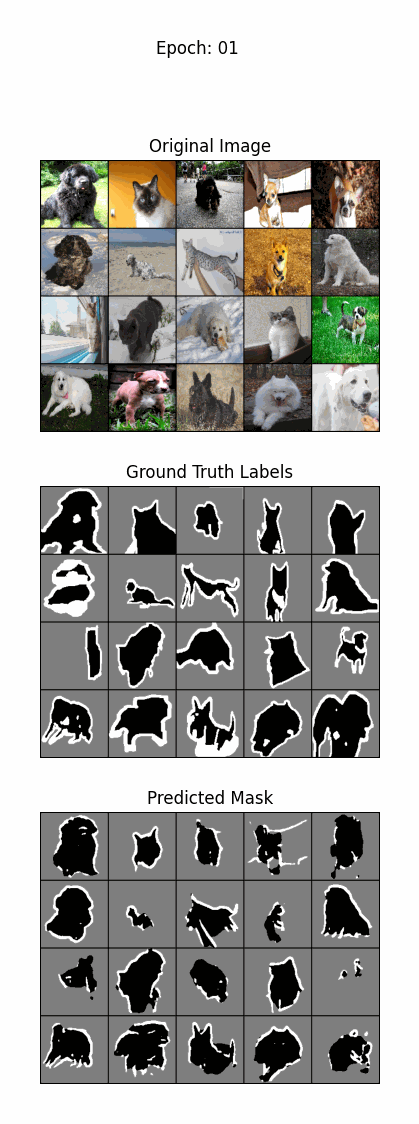

In [4]:
# Display the GIF of the training progress
from IPython.display import Image
Image(filename='runs/Unet/unet_training_progress_images/unet_training_progress.gif',width=300, height=300)


![Unet Training Progress](runs/Unet/unet_training_progress_images/unet_training_progress.gif)

## Experiment 1
Also with in-the-wild samples (meaning images not extracted from the pets dataset: e.g. found online or taken by a smartphone). Does the network perform well over these images?

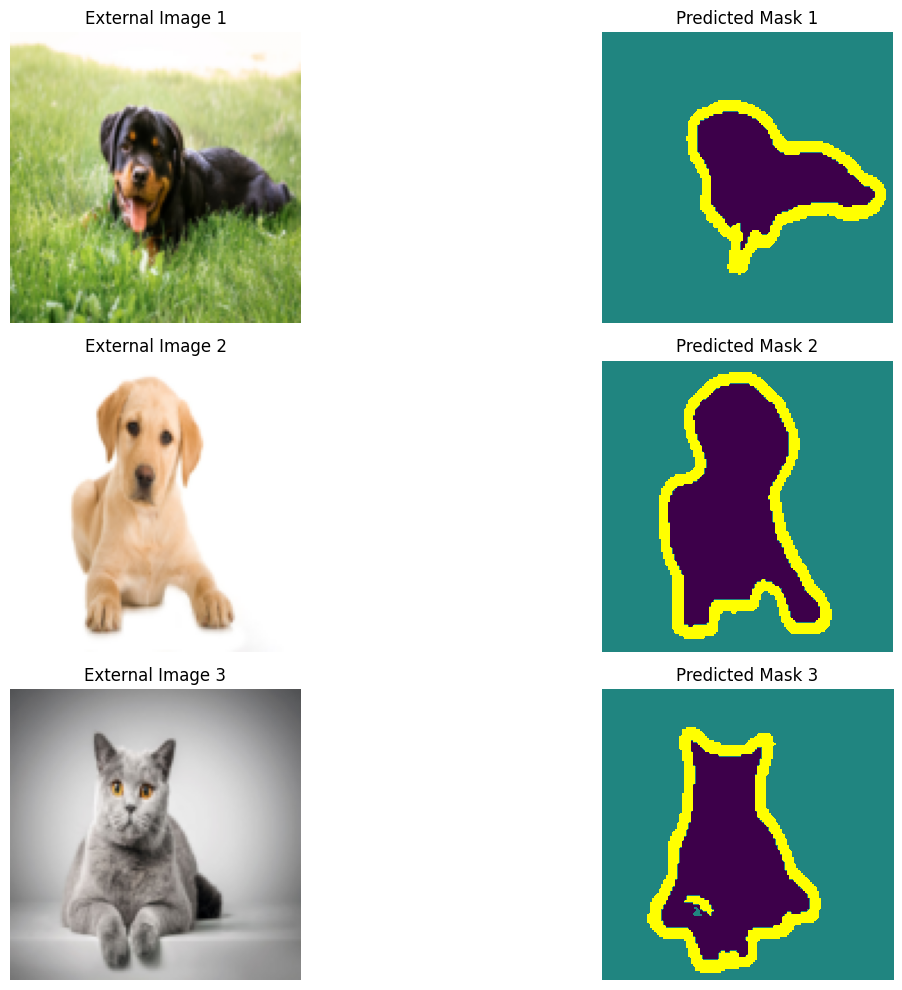

In [30]:
from PIL import Image
from Model import UNet as m
import numpy as np
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = m()
model.load_state_dict(torch.load('runs/Unet/Unet_model.pth', map_location=device))
model.to(device)
model.eval()

def PredMask(image_path, model):
    img = Image.open(image_path).convert('RGB')
    resize = T.Resize((128, 128))
    img = resize(img)
    img = TF.to_tensor(img)
    img = img.unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred = model(img)
    pred = pred.squeeze().cpu().numpy()  
    
    return img.cpu(), pred

# Colormap 
def custom_cmap():
    return mcolors.ListedColormap([
        [61/255, 0, 74/255], # pet
        [32/255, 133/255, 128/255], # background
        [255/255, 255/255, 0], # border
    ])

# images paths
image_paths = ["Images/Cane1.jpg", "Images/Cane2.jpg", "Images/Gatto1.jpg"]

# view images and predicted masks
plt.figure(figsize=(15, 10))

for i, image_path in enumerate(image_paths):
    img, pred = PredMask(image_path, model)
    
    # Softmax and arg
    pred = torch.softmax(torch.tensor(pred), dim=0).argmax(dim=0).numpy()
    
    # Original Image
    plt.subplot(3, 2, i * 2 + 1)
    plt.imshow(np.squeeze(img.numpy()).transpose(1, 2, 0))
    plt.title(f'External Image {i+1}')
    plt.axis('off')
    
    # Predicted Mask
    plt.subplot(3, 2, i * 2 + 2)
    plt.imshow(pred, cmap=custom_cmap())
    plt.title(f'Predicted Mask {i+1}')
    plt.axis('off')
    
plt.tight_layout()
plt.show()


## Experiment 2
That happens if more than on animal is in one image? How does the model perform?

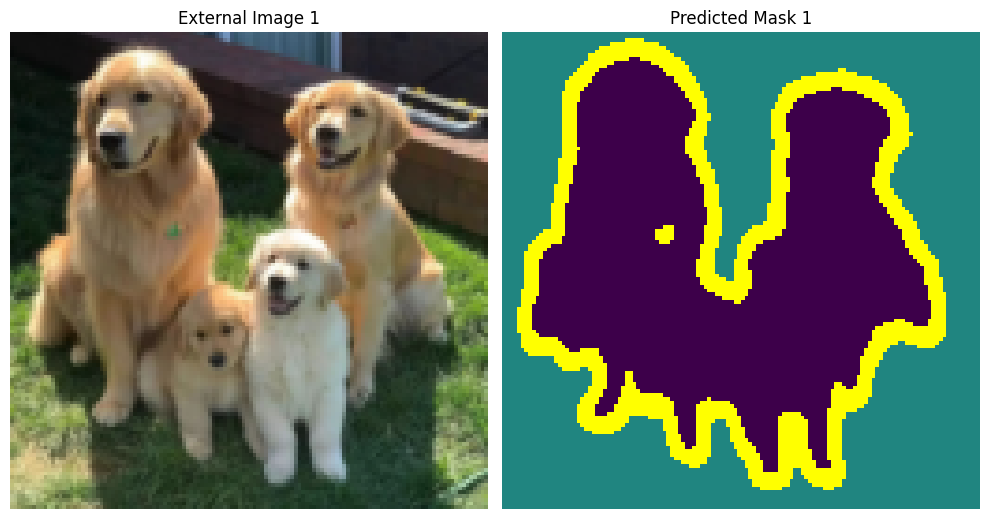

In [32]:
from PIL import Image
from Model import UNet as m
import numpy as np
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = m()
model.load_state_dict(torch.load('runs/Unet/Unet_model.pth', map_location=device))
model.to(device)
model.eval()


def PredMask(image_path, model):
    img = Image.open(image_path).convert('RGB')
    resize = T.Resize((128, 128))
    img = resize(img)
    img = TF.to_tensor(img)
    img = img.unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred = model(img)
    pred = pred.squeeze().cpu().numpy()
    
    return img.cpu(), pred

# Colormap 
def custom_cmap():
    return mcolors.ListedColormap([
        [61/255, 0, 74/255], # pet
        [32/255, 133/255, 128/255], # background
        [255/255, 255/255, 0], # border
    ])

# List of image paths
image_paths = ["Images/Cani.png"]

# Plot the images and predictions
plt.figure(figsize=(10, 12))

for i, image_path in enumerate(image_paths):
    img, pred = PredMask(image_path, model)
    
    # Apply softmax and argmax to get the predicted class indices
    pred = torch.softmax(torch.tensor(pred), dim=0).argmax(dim=0).numpy()
    
    # Original Image
    plt.subplot(1, 2, i * 2 + 1)
    plt.imshow(np.squeeze(img.numpy()).transpose(1, 2, 0))
    plt.title(f'External Image {i+1}')
    plt.axis('off')
    
    # Predicted Mask
    plt.subplot(1, 2, i * 2 + 2)
    plt.imshow(pred, cmap=custom_cmap())
    plt.title(f'Predicted Mask {i+1}')
    plt.axis('off')
    
plt.tight_layout()
plt.show()


## COMPARISON WITH OTHER MODELS

Models:

- **SegNet:** SegNet is a deep convolutional neural network (CNN) designed for image segmentation tasks. Image segmentation involves dividing an image into different segments or regions, typically to identify and classify objects within the image.
    - <u>_Encoder Network_</u>: It consists of convolutional layers, batch normalization, and ReLU activation functions, followed by max-pooling layers. The encoder extracts features from the input image and reduces the spatial dimensions through downsampling.
    - <u>_Decoder Network_</u>: The decoder is responsible for upsampling the feature maps to the original image size. It uses the indices from the max-pooling layers in the encoder to perform upsampling. This allows the network to retain more precise spatial information, which is crucial for accurate segmentation.
    - <u>_Final Classification Layer_</u>: The output of the decoder is passed through a softmax classifier to predict the label for each pixel in the image, resulting in a segmented output where each pixel is assigned a class label.

![SegNet](https://www.researchgate.net/publication/326151825/figure/fig2/AS:647447659438083@1531374959468/Encoder-decoder-architecture-of-SegNet-Inference-takes-place-from-left-to-right-Size-of.png)

<br>

- **DeepLabV3:** DeepLabV3 is a state-of-the-art convolutional neural network architecture designed for semantic image segmentation. DeepLabV3 improves on previous models by incorporating several key techniques to capture more context and achieve more accurate segmentation.

    - <u>_Atrous Convolution (Dilated Convolution)_</u>: DeepLabV3 uses atrous convolutions, which allow the network to capture multi-scale contextual information without increasing the number of parameters or computational cost. This is achieved by introducing gaps (dilations) between the convolutional filter weights, allowing the network to have a larger receptive field and see more of the image context while maintaining the same spatial resolution.
    - <u>_Atrous Spatial Pyramid Pooling (ASPP)_</u>: ASPP is a module within DeepLabV3 that applies multiple parallel atrous convolutions with different dilation rates. This helps the model to capture features at various scales, which is crucial for segmenting objects of different sizes within the same image. The outputs of these convolutions are then combined, allowing the network to merge multi-scale information effectively.
    - <u>_No Decoder in DeepLabV3_</u>: Unlike some other segmentation models, DeepLabV3 does not have a dedicated decoder network. Instead, it relies on the ASPP module and the final convolutional layers to produce the segmentation map directly from the extracted features. 

![DeepLabV3](https://learnopencv.com/wp-content/uploads/2022/12/DeepLabv3-complete_architecture.png)

<br>
<br>

**Results**



<center>
<img src="Images/ComparisonNetwoks.png" alt="Comparison" width="800"/>
</center>

<div style="display: flex; gap: 10px;">

  <div style="text-align: center;">
    <h3>SegNet</h3>
    <img src="runs/SegNet/pred.png" alt="Pred_SegNet" width="400"/>
  </div>

  <div style="text-align: center;">
    <h3>UNet</h3>
    <img src="runs/Unet/pred2.png" alt="Pred_Unet" width="400"/>
  </div>

  <div style="text-align: center;">
    <h3>DeepLabV3</h3>
    <img src="runs/DeepLabV3/pred.png" alt="Pred_DeepLab" width="400"/>
  </div>

</div>

## TENSORBOARD CHARTS


In [4]:
%load_ext tensorboard
%tensorboard --logdir=./runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 2425), started 0:00:06 ago. (Use '!kill 2425' to kill it.)